In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
# Training hyperparameters
epochs = 2
batch_size = 64
learning_rate = 0.01 # DONE
momentum = 0.9
weight_decay = 1e-8 # DONE
log_interval = 20

In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, 
                               kernel_size=5, stride=1, padding=0)
        self.maxpool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, 
                               kernel_size=3, stride=1, padding=0)
        self.fc1 = nn.Linear(in_features=800, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=10)

        nn.init.kaiming_normal_(self.conv1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv2.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='linear')

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = x.view(-1, 800)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [4]:
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, 
                               kernel_size=5, stride=1, padding=2)
        self.maxpool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, 
                               kernel_size=5, stride=1, padding=2)
        self.fc1 = nn.Linear(in_features=3136, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=10)

        nn.init.kaiming_normal_(self.conv1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv2.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='linear')

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = x.view(-1, 3136)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [5]:
class CNN3(nn.Module):
    def __init__(self):
        super(CNN3, self).__init__()
        # TODO        

    def forward(self, x):
        # TODO
        return F.log_softmax(x, dim=1)

In [6]:
def plot_data(data, label, text):
    fig = plt.figure()
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.tight_layout()
        plt.imshow(data[i][0], cmap='gray', interpolation='none')
        plt.title(text + ": {}".format(label[i]))
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [7]:
def predict_batch(model, device, test_loader):
    examples = enumerate(test_loader)
    model.eval()
    with torch.no_grad():
        batch_idx, (data, target) = next(examples)
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.cpu().data.max(1, keepdim=True)[1] # get the index of the max log-probability
        pred = pred.numpy()
    return data.cpu().data.numpy(), target.cpu().data.numpy(), pred

In [8]:
def plot_graph(train_x, train_y, test_x, test_y, ylabel=''):
    fig = plt.figure()
    plt.plot(train_x, train_y, color='blue')
    plt.plot(test_x, test_y, color='red')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.xlabel('number of training examples seen')
    plt.ylabel(ylabel)
    plt.grid()
    plt.show()

In [9]:
def train(model, device, train_loader, optimizer, epoch, losses=[], counter=[], errors=[]):
    model.train()
    correct=0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            losses.append(loss.item())
            counter.append((batch_idx*batch_size) + ((epoch-1)*len(train_loader.dataset)))
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()
    errors.append(100. * (1 - correct / len(train_loader.dataset)))

In [10]:
def test(model, device, test_loader, losses=[], errors=[]):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    losses.append(test_loss)
    errors.append(100. *  (1 - correct / len(test_loader.dataset)))

In [11]:
def main():
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    # data transformation
    train_data = datasets.MNIST('data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
    test_data = datasets.MNIST('data', train=False, 
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

    # data loaders
    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, **kwargs)
    
    # extract and plot random samples of data
    #examples = enumerate(test_loader)
    #batch_idx, (data, target) = next(examples)
    #plot_data(data, target, 'Ground truth')

    # model creation
    model = CNN2().to(device)
    
    #    v v v v v v    #
    #    v v v v v v    #
    #    v v v v v v    #
    
    # OPTIMIZER CREATION
    
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=momentum, weight_decay=1e-8)
    
    # OPTIMIZER CREATION
    
    #    ^ ^ ^ ^ ^ ^    #
    #    ^ ^ ^ ^ ^ ^    #
    #    ^ ^ ^ ^ ^ ^    #

    # lists for saving history
    train_losses = []
    train_counter = []
    test_losses = []
    test_counter = [i*len(train_loader.dataset) for i in range(epochs + 1)]
    train_errors = []
    test_errors = []
    error_counter = [i*len(train_loader.dataset) for i in range(epochs)]

    # test of randomly initialized model
    test(model, device, test_loader, losses=test_losses)

    # global training and testing loop
    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, optimizer, epoch, losses=train_losses, counter=train_counter, errors=train_errors)
        test(model, device, test_loader, losses=test_losses, errors=test_errors)

    # plotting training history
    plot_graph(train_counter, train_losses, test_counter, test_losses, ylabel='negative log likelihood loss')
    plot_graph(error_counter, train_errors, error_counter, test_errors, ylabel='error (%)')

    # extract and plot random samples of data with predicted labels
    data, _, pred = predict_batch(model, device, test_loader)
    plot_data(data, pred, 'Predicted')


Test set: Average loss: 3.9917, Accuracy: 698/10000 (7%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 3.555132
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.520715
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.403321
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.191323
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.223830
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.136662
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.111395
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.030827
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.051259
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.069781
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.051085
Train Epoch: 1 [14080/60000 (23%)]	Loss: 0.092814
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.057932
Train Epoch: 1 [16640/60000 (28%)]	Loss: 0.148924
Train Epoch: 1 [17920/60000 (30%)]	Loss: 0.041780
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.085770
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.090234
Train Epoch: 1 [21760/60000 (36%)]	Loss: 0.018417
Train Epoch: 1 [23040/60000 (38%)]	Loss: 0.048134
Train E

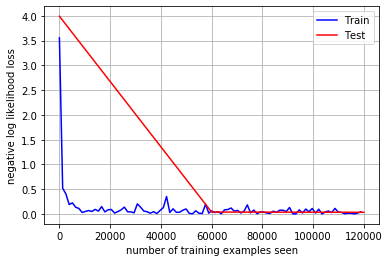

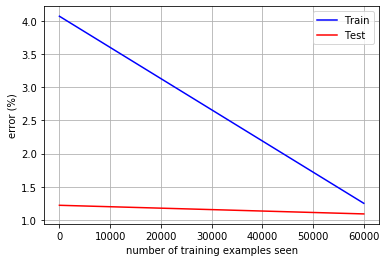

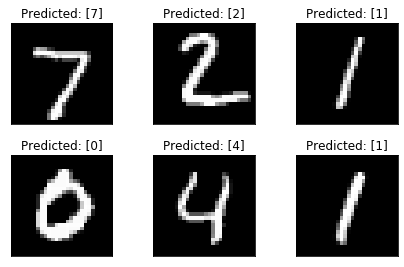

In [12]:
if __name__ == '__main__':
    main()